In [1]:
!pip install ultralytics

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.2/566.2 kB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.3/203.3 kB 21.7 MB/s eta 0:00:00


In [2]:
from ultralytics import YOLO
import numpy as np
from PIL import Image
import requests
from io import BytesIO
import cv2

In [3]:
from google.colab.patches import cv2_imshow


In [4]:
model = YOLO("yolov8n.pt")


100%|██████████| 6.23M/6.23M [00:00<00:00, 14.8MB/s]


In [5]:
# Use the model
model.train(data="VisDrone.yaml", epochs=3)  # train the model
metrics = model.val()  # evaluate model performance on the validation set

Ultralytics YOLOv8.0.97 🚀 Python-3.10.11 torch-2.0.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
yolo/engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=VisDrone.yaml, epochs=3, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes=True, format=torchscript, keras=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=None, workspac

In [6]:
from PIL import Image
import io
import pathlib

with open("TRAFFIC.jpeg", "rb") as f:
    image = Image.open(io.BytesIO(f.read()))
    image = image.resize((1024, 720))
    image = np.asarray(image)

In [7]:
results = model.predict(image)



0: 480x640 3 pedestrians, 5 cars, 1 van, 82.5ms
Speed: 3.0ms preprocess, 82.5ms inference, 1.9ms postprocess per image at shape (1, 3, 640, 640)


In [8]:
print(results[0].boxes.boxes)

WARNING ⚠️ 'Boxes.boxes' is deprecated. Use 'Boxes.data' instead.


tensor([[2.7297e+01, 6.3322e+02, 1.1273e+02, 7.2000e+02, 8.9957e-01, 3.0000e+00],
        [7.6081e+02, 5.3414e+02, 8.9544e+02, 6.5159e+02, 7.0593e-01, 3.0000e+00],
        [5.6886e+02, 3.4332e+02, 6.7784e+02, 4.4706e+02, 5.8961e-01, 3.0000e+00],
        [2.6937e+02, 4.6274e+01, 3.1670e+02, 1.0099e+02, 5.8796e-01, 3.0000e+00],
        [8.0064e+02, 5.5426e+01, 8.1320e+02, 7.5874e+01, 3.9808e-01, 0.0000e+00],
        [5.6764e+02, 3.4450e+02, 6.7806e+02, 4.4528e+02, 3.8253e-01, 4.0000e+00],
        [8.5975e+02, 3.3322e+01, 8.7413e+02, 6.2044e+01, 3.4218e-01, 0.0000e+00],
        [9.0947e+02, 6.5920e+02, 1.0058e+03, 7.2000e+02, 3.0016e-01, 3.0000e+00],
        [3.3825e+02, 2.5299e+02, 3.5575e+02, 2.7914e+02, 2.5933e-01, 0.0000e+00]], device='cuda:0')


In [9]:
def box_label(image, box, label='', color=(128, 128, 128), txt_color=(255, 255, 255)):
  lw = max(round(sum(image.shape) / 2 * 0.003), 2)
  p1, p2 = (int(box[0]), int(box[1])), (int(box[2]), int(box[3]))
  cv2.rectangle(image, p1, p2, color, thickness=lw, lineType=cv2.LINE_AA)
  if label:
    tf = max(lw - 1, 1)  # font thickness
    w, h = cv2.getTextSize(label, 0, fontScale=lw / 3, thickness=tf)[0]  # text width, height
    outside = p1[1] - h >= 3
    p2 = p1[0] + w, p1[1] - h - 3 if outside else p1[1] + h + 3
    cv2.rectangle(image, p1, p2, color, -1, cv2.LINE_AA)  # filled
    cv2.putText(image, label, (p1[0], p1[1] - 2 if outside else p1[1] + h + 2), 0, 
                lw / 3, txt_color, thickness=tf, lineType=cv2.LINE_AA)

In [10]:
def plot_bboxes(image, boxes, labels=[], colors=[], score=True, conf=None):
  #Define COCO Labels
  if labels == []:
    labels = {0: u'__background__', 1: u'pedestrian', 2: u'people',3: u'bicycle', 4: u'car', 5: u'van', 
              6: u'truck', 7: u'tricycle', 8: u'awning-tricycle', 9: u'bus', 10: u'motor', 11: u''}
  #Define colors
  if colors == []:
    colors = [(89, 161, 197), (67, 161, 255), (19, 222, 24), (186, 55, 2), (167, 146, 11), (190, 76, 98), 
     (130, 172, 179), (115, 209, 128), (204, 79, 135), (136, 126, 185),  (209, 213, 45), (44, 52, 10)]
  
  #plot each boxes
  for box in boxes:
    #add score in label if score=True
    if score :
      label = labels[int(box[-1])+1] + " " + str(round(100 * float(box[-2]),1)) + "%"
    else :
      label = labels[int(box[-1])+1]
    #filter every box under conf threshold if conf threshold setted
    if conf :
      if box[-2] > conf:
        color = colors[int(box[-1])]
        box_label(image, box, label, color)
    else:
      color = colors[int(box[-1])]
      box_label(image, box, label, color)

  #show image
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

  try:
    import google.colab
    IN_COLAB = True
  except:
    IN_COLAB = False

  if IN_COLAB:
    cv2_imshow(image) #if used in Colab
  else :
    cv2.imshow(image) #if used in Python

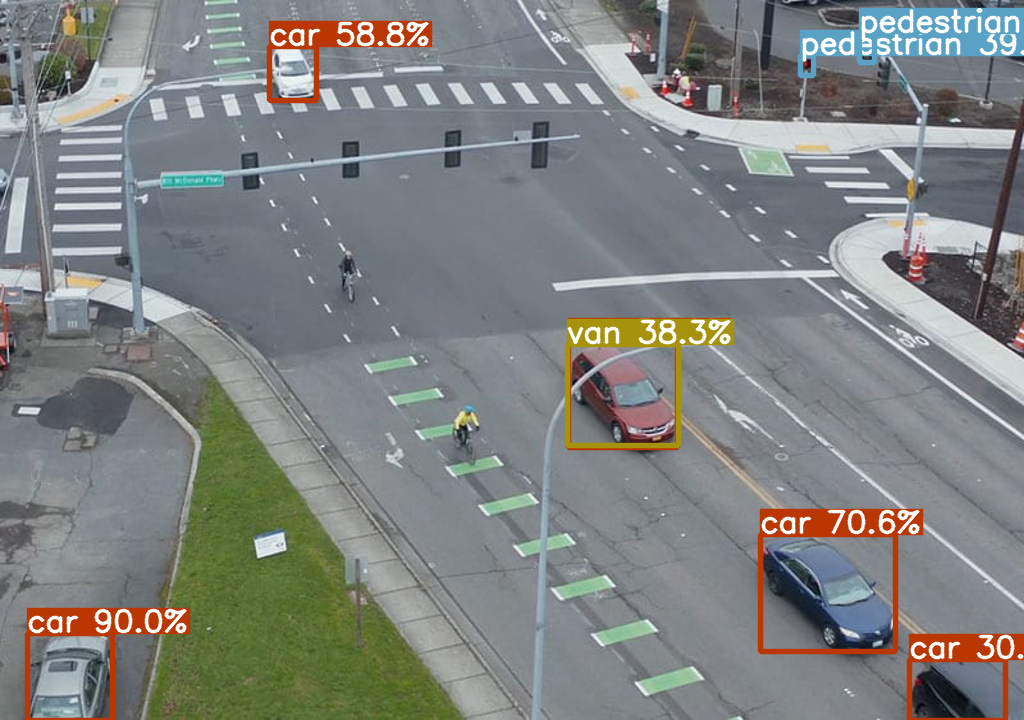

In [11]:
plot_bboxes(image, results[0].boxes.data, conf=0.3)